# Tree-based (Ensemble) Models and Handling Imbalanced Data [30 points]

For this problem, we will use the wine quality dataset on which the task is a binary classification of whether a given wine is of low or high quality based on different physicochemical features.
 
The dataset consists of a set of physicochemical features as inputs and the target is wine quality stored in the target column, where a value of 1 corresponds to an instance of high quality wine and -1 corresponds to an instance of low quality ones.

### Loading the data (3pts)
Load the data from library.

In [1]:
# Use wine dataset from imlearn
from imblearn.datasets import fetch_datasets
import numpy as np
import pandas as pd

datasets = fetch_datasets()

# Wine quality dataset contains 12 features, descriptions found here: 
# https://archive.ics.uci.edu/ml/datasets/wine+quality
data = datasets['wine_quality']

X, y = data.data, data.target

# Use X_train, X_test, y_train, y_test for all of the following questions
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Using TensorFlow backend.


**Question:** Draw the class distribution of the dataset. What are possible problems if we train a classification model directly on this dataset?

The data is imbalanced. Percenage of negative instances is much larger than that of positive instances.

In [2]:
# import libraries for plotting class distribution
import matplotlib.pyplot as plt
import seaborn as sns

high_quality_ratio = len([i for i in y if i==1])/len(y)
print('Percentage of high quality observations', high_quality_ratio)

# color coding for 2 classes
colors = ["#0101DF", "#DF0101"]
## code to plot the class distribution. Hint: countplot in seaborn
sns.countplot(x=y,palette=colors)

Percentage of high quality observations 0.03736218864842793


### Training and testing a Random Forest classfier directly on the data (3pts)

Let's first train a random forest classifier with default parameters using X_train and y_train and test the performance on the test data.

In [3]:
from sklearn.ensemble import RandomForestClassifier # class for random forest classifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

## Instantiate and fit a random forest classifier to the training data
rf=RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
## Measure and print out the accuracy and recall
test_acc = (y_test_pred==y_test).sum()/len(y_test)

print('Random forest classifier accuray:', test_acc)

test_recall = recall_score(y_test,y_test_pred)

print('Random forest classifier recall:', test_recall)

Random forest classifier accuray: 0.9510204081632653
Random forest classifier recall: 0.10606060606060606


**Quetion:** Compute the recall and accuracy scores of the random forest classifier. How is the gap between the accuracy and recall scores? Provide an explanation.

The accuracy is high while the recall rate is very low.

Resons:
a) The default parameter of "average" in recall_score is "binary", which will only reports results for class specified by pos_lable, which is 1. 
b) The rate is low since the train data is imbanlanced and there are few positive samples, thus the model cannot predict positive labels well.
c) While for accuracy, it's computed based on results of 2 classes, and positive class has very small proportion, so the lobal accuracy rate is really high and the "binary" recall rate for positive labels is really low.
d) If we use average='weighted', than the gap can be eliminated since it's computed on global view.

### Data balancing via Smote (6pts)

In [4]:
from imblearn.over_sampling import SMOTE #Over sampling
import numpy as np

## Instantiate smote and balance training data only
sm=SMOTE(random_state=42)
X_train_res,y_train_res=sm.fit_resample(X_train,y_train)
## Compute and print percentage of high quality wine after balancing
print('Percentage of high quality counts in the balanced data:{}%'.format(sum(y_train_res==1)*100/len(y_train_res)))

Percentage of high quality counts in the balanced data:50.0%


**Question:** Plot the distribution of balanced training data.

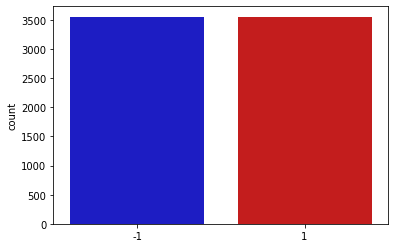

In [5]:
colors = ["#0101DF", "#DF0101"]
## plot the class distribution of training data after balanced
sns.countplot(x=y_train_res,palette=colors)

Let's retrain and test our random forest model on the balanced training data

In [6]:
## Instantiate random forest and train on balanced training data
# X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, random_state=0)
rf2=RandomForestClassifier(random_state=42)
rf2.fit(X_train_res, y_train_res)
y_test_pred=rf2.predict(X_test)
test_acc = sum(y_test_pred==y_test)/len(y_test)

print('Random forest classifier accuray:', test_acc)

test_recall = recall_score(y_test,y_test_pred)

print('Random forest classifier recall:', test_recall)

Random forest classifier accuray: 0.9469387755102041
Random forest classifier recall: 0.3181818181818182


In [7]:
#test
TP=sum(y_test[y_test_pred==1]==1)
print('TP is:',TP)
FN=sum(y_test[y_test_pred==-1]==1)
print('FN is:',FN)
TP/(TP+FN)

TP is: 21
FN is: 45


0.3181818181818182

**Question:** Compute the recall and accuracy scores of the new random forest classifier. How do the accuracy and recall change compared to those without data balancing?

a) The accuracy decrease a bit since the threshold of positive labels is lower and will have more false positive cases
b) Recall score increase since the training samples with positive labels increase and the model now can have better prediction for positive labels

### Control complexity of the model (18pts)

#### Control the depth of decision trees in our ensemble (6pts)
By default, the decision trees in random forest are expanded until all leaves are pure or until all leaves contain less than a certain number set by min_samples_split parameter. Let's try a fixed maximum depth that the tree can expand.

In [8]:
## Instantiate model with max depth trees being 3
rf3=RandomForestClassifier(max_depth=3,random_state=42)
rf3.fit(X_train_res, y_train_res)
y_test_pred=rf3.predict(X_test)
test_acc = sum(y_test_pred==y_test)/len(y_test)

print('Random forest classifier accuray:', test_acc)

test_recall = recall_score(y_test,y_test_pred)

print('Random forest classifier recall:', test_recall)

Random forest classifier accuray: 0.8448979591836735
Random forest classifier recall: 0.5757575757575758


**Question:** Compute the recall and accuracy scores of the new random forest classifier. How do the accuracy and recall change compared to those in the default parameter case?

The accuracy is lower since the max depth is fixed and may lead to underfitting.
The recall is higher.

In [9]:
#test
TP=sum(y_test[y_test_pred==1]==1)
print('TP is:',TP)
FN=sum(y_test[y_test_pred==-1]==1)
print('FN is:',FN)
TP/(TP+FN)

TP is: 38
FN is: 28


0.5757575757575758

#### Choose the number of trees in the forest (6pts)
By default, we use 10 random trees. Let's increase this number to 100

In [13]:
## Instantiate model with max depth of 3 and 100 decision trees
rf4=RandomForestClassifier(max_depth=3,random_state=42,n_estimators=1000)
rf4.fit(X_train_res, y_train_res)
y_test_pred=rf4.predict(X_test)
test_acc = sum(y_test_pred==y_test)/len(y_test)

print('Random forest classifier accuray:', test_acc)

test_recall = recall_score(y_test,y_test_pred)

print('Random forest classifier recall:', test_recall)

Random forest classifier accuray: 0.8318367346938775
Random forest classifier recall: 0.5454545454545454


**Question:** Compute the recall and accuracy scores of the random forest classifier. How do the accuracy and recall change compared to those with 10 trees? What do the results imply about increasing the number of trees?

Note: Since the default n_estimators is 100 rather than 10, which is the default value mentioned in the question, so here I use n_estimators=1000 to compare.
The accuracy and recall both decrease, maybe too many trees cause overfit.

#### Tree pruning by min_impurity_decrease (6pts)
By default, the tree keeps expanding until the impurity is 0. However, we can specify a minimum impurity decrease amount under which nodes in the tree stop branching. RandomForestClassifier in sklearn use min_impurity_decrease for setting this threshold. Let's try that on our problem.

In [15]:
## Instantiate model with min impurity decrease of 0.001
rf5=RandomForestClassifier(random_state=42,min_impurity_decrease=0.001)
rf5.fit(X_train_res, y_train_res)
y_test_pred=rf5.predict(X_test)
test_acc = sum(y_test_pred==y_test)/len(y_test)

print('Random forest classifier accuray:', test_acc)

test_recall = recall_score(y_test,y_test_pred)

print('Random forest classifier recall:', test_recall)

Random forest classifier accuray: 0.9151020408163265
Random forest classifier recall: 0.4696969696969697


**Question:** Compute the recall and accuracy scores of the random forest classifier. How does the recall change compared to those with 10 trees and max_depth = 3?

The accuracy increase and recall decrease. Since seting a minimum impurity can prevent overfitting.